# How to train the Baseline Models

### This notebook will show how to
- instantiate dataloader for the all 7 datasets of the competition
- build and train a `Generalization` model, that is trained on all 7 datasets
- compute the performance metrics on the test set of all the "pre-training" recordings (where the "live test set" is available)
- get the estimated receptive field positions of the neurons (i.e. the model readout position)
- visualize retinotopy: showing the correspondence between receptive fields and the anatomical coordinates within V1

### Imports

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from nnfabrik.builder import get_data, get_model, get_trainer

### Instantiate DataLoader

In [2]:
import os

basepath = "../data/"

# as filenames, we'll select all 7 datasets
filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
filenames = [filenames[-2]] # Comment for all paths

dataset_fn = 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':.25,
                 }

dataloaders = get_data(dataset_fn, dataset_config)

now, our dataloaders contain one `data_key` (or "dataset_name") for each dataset

In [3]:
dataloaders

OrderedDict([('train',
              OrderedDict([('26872-17-20',
                            <torch.utils.data.dataloader.DataLoader at 0x14ed3e56dca0>)])),
             ('validation',
              OrderedDict([('26872-17-20',
                            <torch.utils.data.dataloader.DataLoader at 0x14ed3e56dd30>)])),
             ('test',
              OrderedDict([('26872-17-20',
                            <torch.utils.data.dataloader.DataLoader at 0x14ed3e56dc70>)])),
             ('final_test',
              OrderedDict([('26872-17-20',
                            <torch.utils.data.dataloader.DataLoader at 0x14ed3e56de50>)]))])

# Instantiate State of the Art Model (SOTA)

In [4]:
model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
  'layers': 4,
  'input_kern': 9,
  'gamma_input': 6.3831,
  'gamma_readout': 0.0076,
  'hidden_kern': 7,
  'hidden_channels': 64,
  'depth_separable': True,
  'grid_mean_predictor': {'type': 'cortex',
   'input_dimensions': 2,
   'hidden_layers': 1,
   'hidden_features': 30,
   'final_tanh': True},
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',
  'shifter': False,
  'stack': -1,
}

model = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders,
                  seed=42,)

The model has one shared core, but for each dataset, it has a separate readout and shifter network

In [5]:
print(model)

FiringRateEncoder(
  (core): Stacked2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (spatial_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), s

## Configure Trainer

In [6]:
trainer_fn = "sensorium.training.standard_trainer"

trainer_config = {'max_iter': 200,
                 'verbose': False,
                 'lr_decay_steps': 4,
                 'avg_loss': False,
                 'lr_init': 0.009,
                 }

trainer = get_trainer(trainer_fn=trainer_fn, 
                     trainer_config=trainer_config)

# Run model training

In [7]:
validation_score, trainer_output, state_dict = trainer(model, dataloaders, seed=42)

Epoch 104: 100%|██████████| 252/252 [00:21<00:00, 11.76it/s]


In [8]:
validation_score

0.33370963

In [10]:
torch.save(model.state_dict(), './model_checkpoints/generalization_model.pth')

# (or load our pretrained checkpoints)

In [15]:
model.load_state_dict(torch.load("./model_checkpoints/sensorium_sota_model_apptainer.pth"));

In [16]:
model.eval();

---

# Model evaluation

In [17]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

## Single Trial Correlation

In [18]:
single_trial_correlation = get_correlations(model, dataloaders, tier="test", device="cuda", as_dict=True)


In [19]:
print(single_trial_correlation)

{'26872-17-20': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}


In [20]:
# {'23964-4-22': array([0.26151043, 0.3814846 , 0.17598262, ..., 0.4230086 , 0.33803117,
#        0.25610375], dtype=float32), '22846-10-16': array([0.266038  , 0.20294003, 0.29464984, ..., 0.4054811 , 0.61702806,
#        0.41553646], dtype=float32), '26872-17-20': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), '23343-5-17': array([0.15239973, 0.35486415, 0.22091451, ..., 0.3491108 , 0.19907376,
#        0.36671603], dtype=float32), '21067-10-18': array([0.52615935, 0.09481911, 0.07467279, ..., 0.20906341, 0.3221193 ,
#        0.16712782], dtype=float32), '27204-5-13': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), '23656-14-22': array([0.26868233, 0.4579676 , 0.36620876, ..., 0.4610656 , 0.414044  ,
#        0.3021411 ], dtype=float32)}

In [21]:
df = get_df_for_scores(session_dict=single_trial_correlation,
                                    measure_attribute="Single Trial Correlation"
                      )

In [22]:
df[df["dataset"] == "26872-17-20"]["Single Trial Correlation"].mean()

0.0

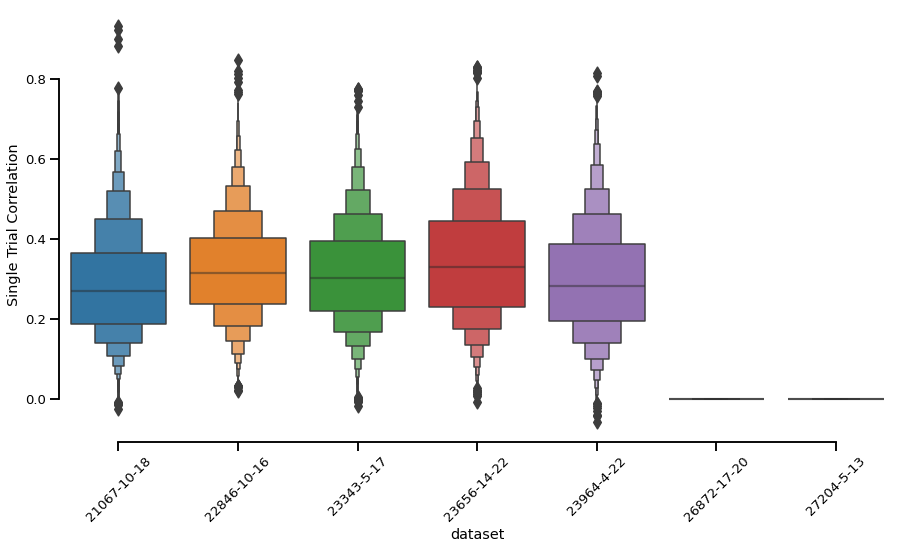

In [16]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)

**Note** how for two datasets, the correlations are 0. Those are our 2 competition scans, for which the test data is withheld.

## Correlation to Average

In [17]:
correlation_to_average = get_signal_correlations(model, dataloaders, tier="test", device="cuda", as_dict=True)


In [18]:
measure_attribute = "Correlation to Average"
df = get_df_for_scores(session_dict=correlation_to_average,
                                    measure_attribute=measure_attribute,
                      )

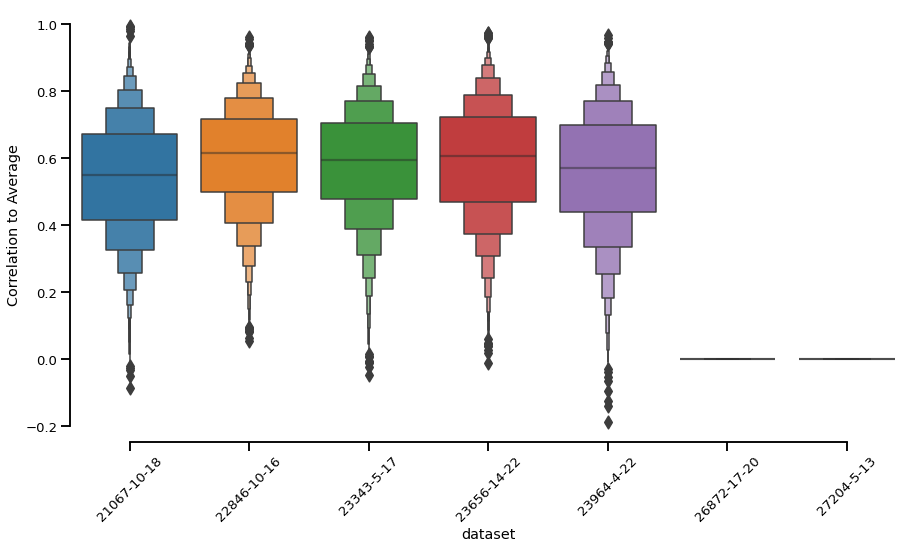

In [19]:
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y=measure_attribute, data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)

## Fraction of explainable variance explained

In [20]:
feves = get_fev(model, dataloaders, tier="test", device="cuda", as_dict=True)


In [21]:
measure_attribute = "FEVE"
df = get_df_for_scores(session_dict=feves,
                                    measure_attribute=measure_attribute,
                      )

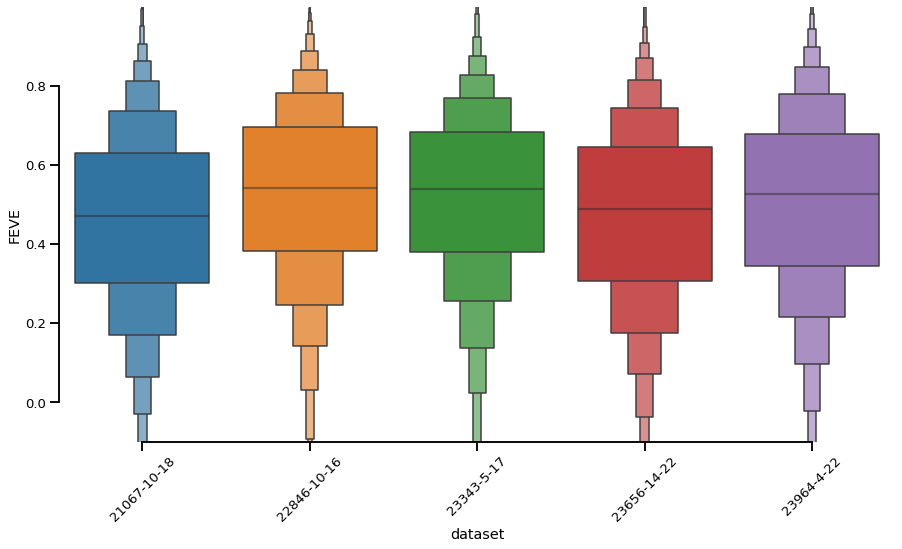

In [22]:
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y=measure_attribute, data=df, )
plt.xticks(rotation = 45);
plt.ylim([-.1, 1])
sns.despine(trim=True)

---

# Show Readout Positions 

This section of the notebook shows how the model is learning retinotopy:
we show how the readout position of the each neuron (i.e. the receptive field center) corresponds to its coordinates within visual cortex.

In [22]:
from PIL import ImageColor
from sensorium.utility.measure_helpers import ColorMap2D, get_base_colormap, get_color

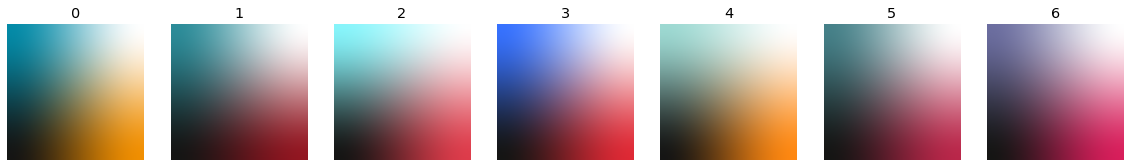

In [23]:
# set up a few appealing color gradients
colors = [['#048BA8', '#FFFFFF','#151514','#F18F01'],
           ['#2C8C99', '#FFFFFF','#151514','#931621'],
           ['#87F5FB', '#FFFFFF','#151514','#DE3C4B'],
           ['#3772FF', '#FFFFFF','#151514','#DF2935'],
           ['#9DD9D2', '#FFFFFF','#151514','#FF8811'],
           ['#468189', '#FFFFFF','#151514','#BA274A'],
           ['#6C6EA0', '#FFFFFF','#151514','#D81E5B'],]

fig, axs = plt.subplots(1, len(colors), figsize=(20,5))
for i, ax in enumerate(axs.ravel()):
    rgb_colors = [ImageColor.getcolor(i, "RGB") for i in colors[i]]
    img = get_base_colormap(*rgb_colors, interpolation="smooth")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(str(i))

### Sensorium dataset

In [24]:
dataset_name = "26872-17-20"

In [25]:
cell_motor_coordinates = (dataloaders["train"][dataset_name].dataset.neurons.cell_motor_coordinates)

readout_pos = model.readout[dataset_name].mu.squeeze().detach().cpu().numpy()

### Readout Positions (i.e. Receptive field centers relative to the center of the presented image)

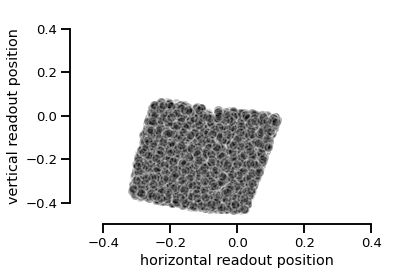

In [26]:
plt.scatter(*readout_pos.T, alpha=.25, c="k", edgecolor="w")
plt.xlim([-.5, .5])
plt.ylim([-.5, .5])
plt.xlabel("horizontal readout position")
plt.ylabel("vertical readout position")
sns.despine(trim=True)

## Relating the Readout locations to the Anatomical Coordinates

Text(0, 0.5, 'y coordinate (μm)')

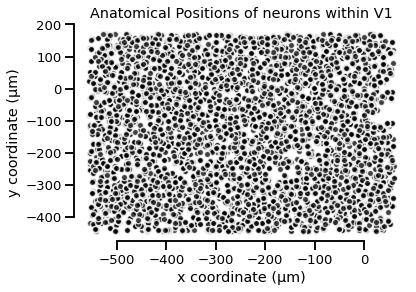

In [27]:
# show anatomical coordinates of all Neurons of this dataset
plt.scatter(cell_motor_coordinates[:, 0],cell_motor_coordinates[:,1] ,c='k',edgecolor="w", alpha=.75, s=40,)
sns.despine(trim=True)
plt.title("Anatomical Positions of neurons within V1")
plt.xlabel('x coordinate (μm)')
plt.ylabel('y coordinate (μm)')

### Now we color each neuron with a color based on the RF center

### Now we color each neuron with a color based on the RF center

In [28]:
# instantiate 2D Colormap Class with the base colormap
Cmap_2D = ColorMap2D(img,) 
cbar_rgb = Cmap_2D.generate_cbar()

# get RGB tuples for all readout positions based on the colormap
# set vmin/vmax to +- .25
rgb = Cmap_2D(*readout_pos.T.clip(-.25,.25))

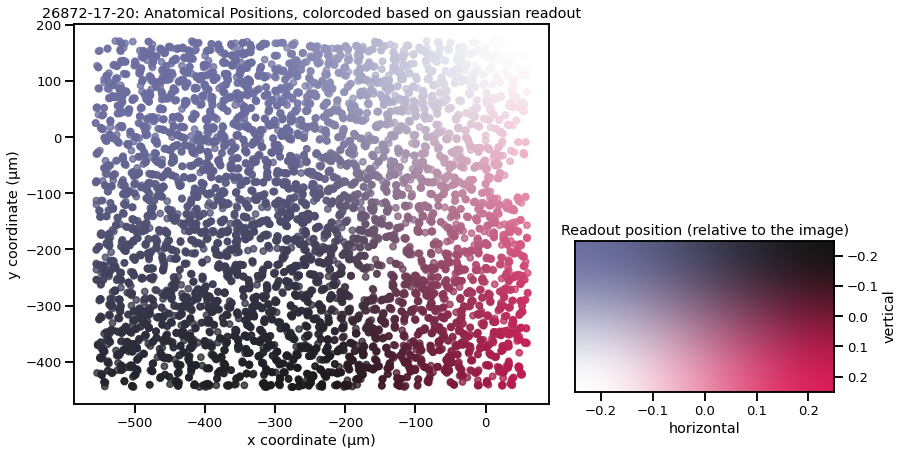

In [29]:
fig, ax = plt.subplots(figsize=(12, 7))

# Show Anatomical Positions
ax.scatter(cell_motor_coordinates[:, 0],cell_motor_coordinates[:,1] ,c=rgb.squeeze(), alpha=.75, s=40,)
ax.set_title(f"{dataset_name}: Anatomical Positions, colorcoded based on gaussian readout")
ax.set_xlabel('x coordinate (μm)')
ax.set_ylabel('y coordinate (μm)')

plt.subplots_adjust(left=0.1, right=0.65)

# Show 2D Colormap of the Gaussian Readout
bar_ax = fig.add_axes([0.68, 0.15, 0.3, 0.3])
cmap_extent = (-.25, .25, -.25, .25)
bar_ax.imshow(cbar_rgb, extent=cmap_extent, aspect='auto',origin="lower")

bar_ax.set_title(f'Readout position (relative to the image)')
bar_ax.set_xlabel('horizontal')
bar_ax.set_ylabel('vertical')
bar_ax.yaxis.tick_right()
bar_ax.yaxis.set_label_position('right')
bar_ax.invert_yaxis()

plt.show()

# Repeat for all 7 sessions

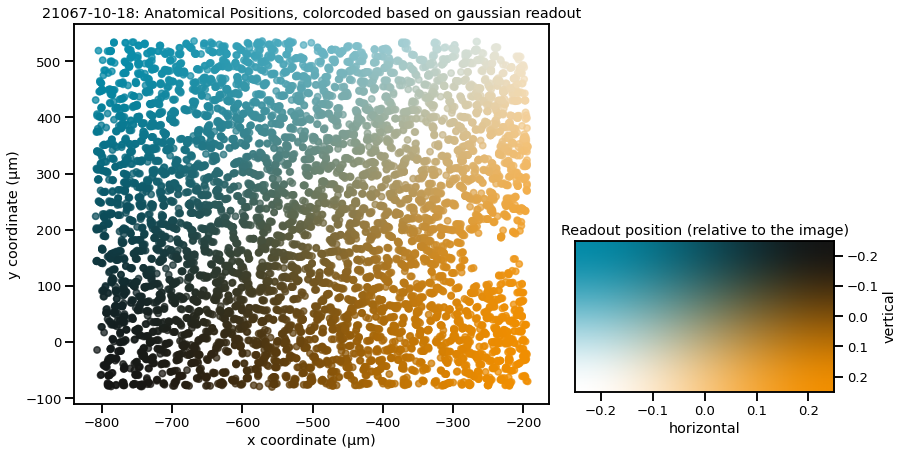

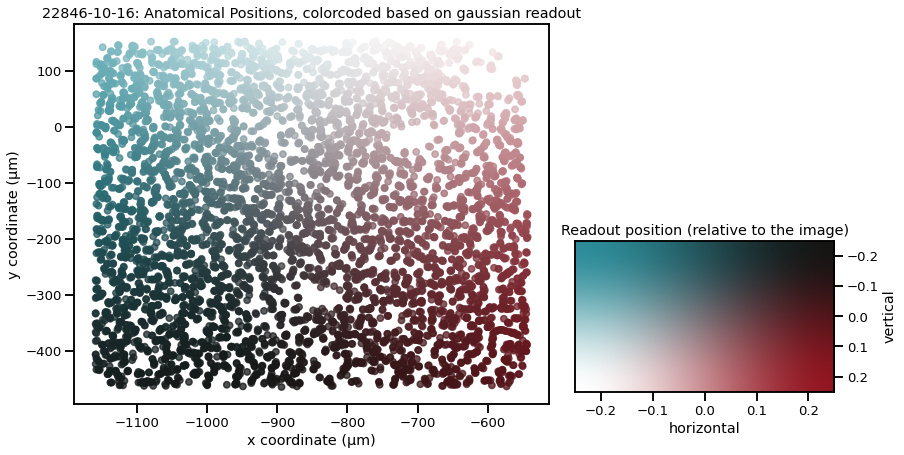

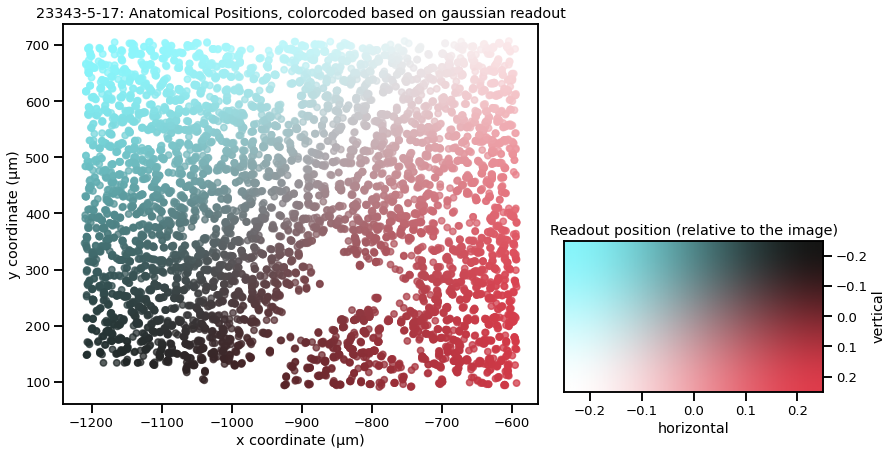

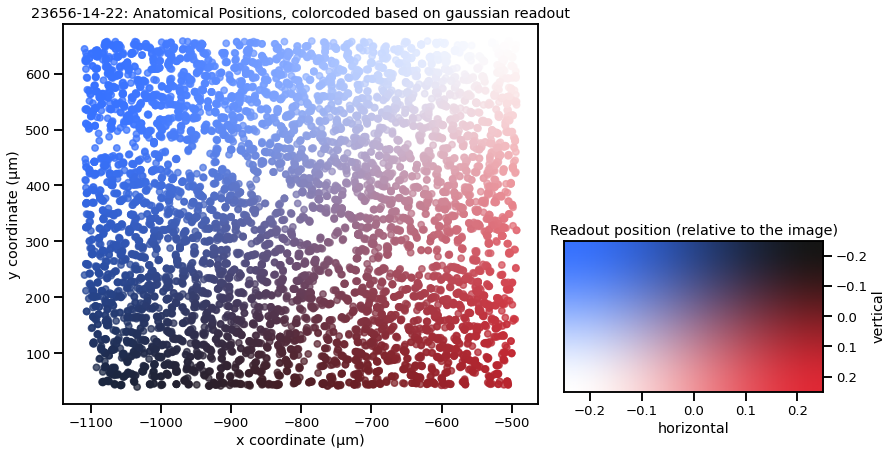

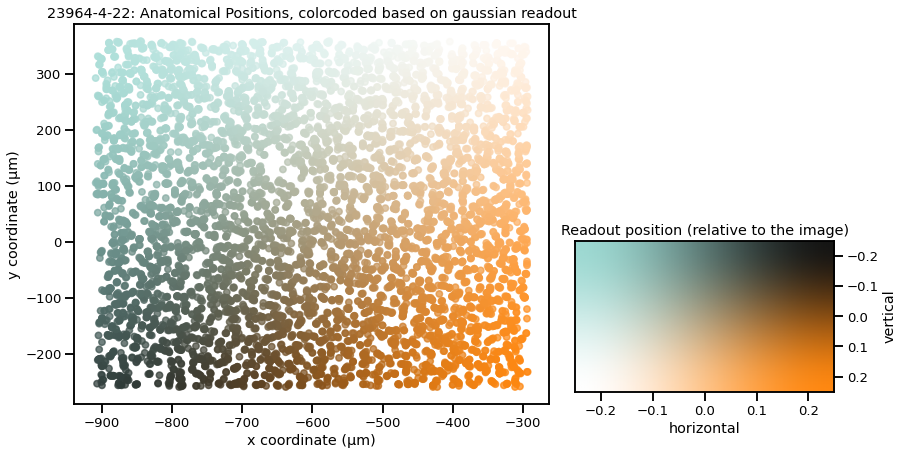

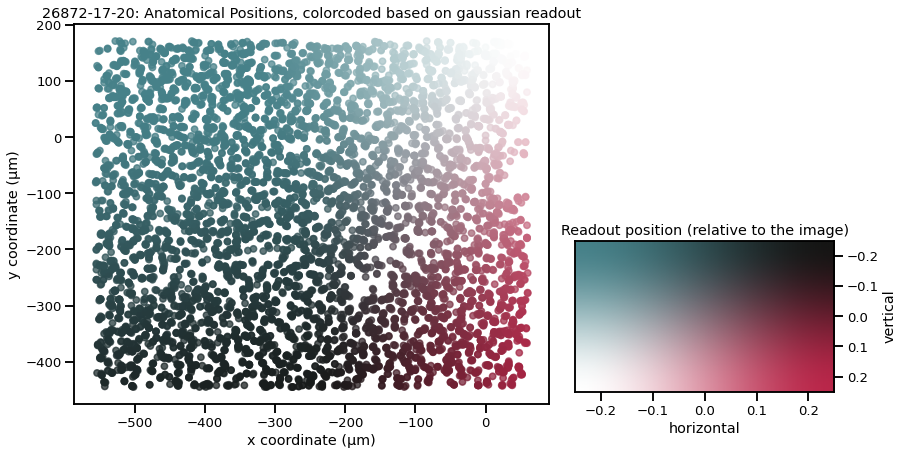

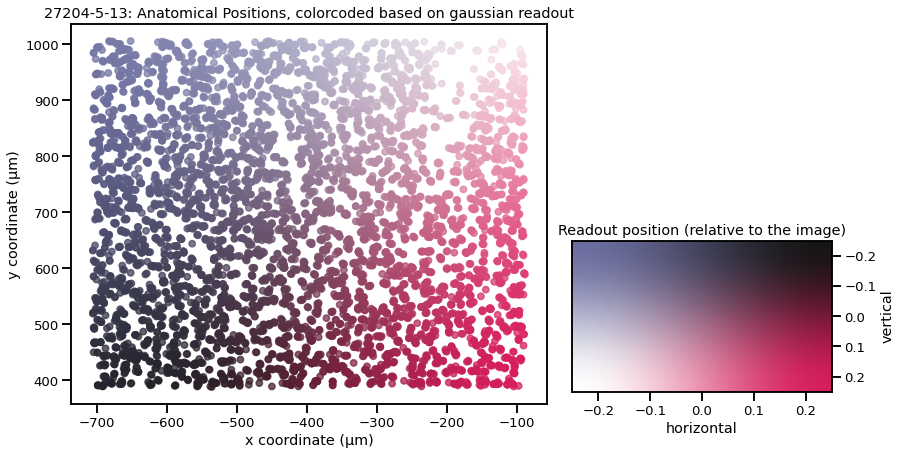

In [30]:
for i, (dataset_name, dataloader) in enumerate(dataloaders["train"].items()):
    
    # get anatomical and model readout coordinates
    cell_motor_coordinates = (dataloaders["train"][dataset_name].dataset.neurons.cell_motor_coordinates)
    readout_pos = model.readout[dataset_name].mu.squeeze().detach().cpu().numpy()
    
    # get colormap
    rgb_colors = [ImageColor.getcolor(j, "RGB") for j in colors[i]]
    img = get_base_colormap(*rgb_colors, interpolation="smooth")
    Cmap_2D = ColorMap2D(img,) 
    cbar_rgb = Cmap_2D.generate_cbar()
    rgb = Cmap_2D(*readout_pos.T.clip(-.25,.25))
    
    fig, ax = plt.subplots(figsize=(12, 7))

    # Show Anatomical Positions
    ax.scatter(cell_motor_coordinates[:, 0],cell_motor_coordinates[:,1] ,c=rgb.squeeze(), alpha=.75, s=40,)
    ax.set_title(f"{dataset_name}: Anatomical Positions, colorcoded based on gaussian readout")
    ax.set_xlabel('x coordinate (μm)')
    ax.set_ylabel('y coordinate (μm)')

    plt.subplots_adjust(left=0.1, right=0.65)

    # Show 2D Colormap of the Gaussian Readout
    bar_ax = fig.add_axes([0.68, 0.15, 0.3, 0.3])
    cmap_extent = (-.25, .25, -.25, .25)
    bar_ax.imshow(cbar_rgb, extent=cmap_extent, aspect='auto',origin="lower")

    bar_ax.set_title(f'Readout position (relative to the image)')
    bar_ax.set_xlabel('horizontal')
    bar_ax.set_ylabel('vertical')
    bar_ax.yaxis.tick_right()
    bar_ax.yaxis.set_label_position('right')
    bar_ax.invert_yaxis()

    plt.show()